In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

%run "Fonctions.ipynb"

In [110]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

In [126]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

'time_20170620143533742'

In [36]:
test = recover_sig('../Millau/Resultats/2017-06-20-hh-mm-ss/2017-06-20-00-mm-ss/2017-06-20-00-03-34-150.txt', ['A07'])

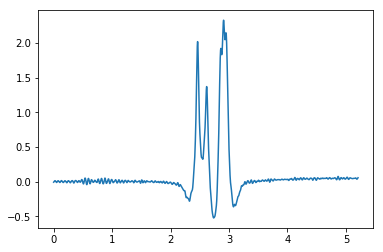

In [40]:
plt.plot(test['time'], test['A07'])
plt.show()